Goal is to attribute transformer output to either earlier positions or lower layers

First apply the full model forward from Token through to LM Head without attribution

In [4]:
from transformer_utils.low_memory import enable_low_memory_load
import transformers

enable_low_memory_load()
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
model = transformers.AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-neo-125M')

c:\users\stephenprior\appdata\local\programs\python\python39\lib\site-packages\torch\nn\modules\lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
from src.visualization import visualize

In [8]:
text = "The forecast said that thunderstorm activity with the risk of hail will lead to localised"
tokens = visualize.text_to_input_ids(tokenizer, text)
tokens, tokens.shape

(tensor([[  464, 11092,   531,   326, 18355, 12135,  3842,   351,   262,  2526,
            286, 32405,   481,  1085,   284,  1957,  1417]], device='cuda:0'),
 torch.Size([1, 17]),
 17)

In [14]:
tokenizer.batch_decode(tokens), [tokenizer.decode(token) for token in tokens[0]]

(['The forecast said that thunderstorm activity with the risk of hail will lead to localised'],
 ['The',
  ' forecast',
  ' said',
  ' that',
  ' thunder',
  'storm',
  ' activity',
  ' with',
  ' the',
  ' risk',
  ' of',
  ' hail',
  ' will',
  ' lead',
  ' to',
  ' local',
  'ised'])

In [5]:
model

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=0, out_features=768, bias=False)
            (v_proj): Linear(in_features=0, out_features=768, bias=False)
            (q_proj): Linear(in_features=0, out_features=768, bias=False)
            (out_proj): Linear(in_features=0, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=0, out_features=3072, bias=True)
          (c_proj): Linear(in_features=0, out_features=7

In [15]:
expected_token_id = 17448
tokenizer.decode(expected_token_id)

' flooding'

Apply the Captum Integrated Gradients algorithm to attribute this token to the input embedding vectors.
We don't use the GPTNeoForCausalLM model because it is not straightforward to apply attribution to the embedding step (though it should be possible using [Captum Interpretable Embeddings](https://captum.ai/api/utilities.html#interpretable-embeddings) )
The model is wrapped in a function to allow transformer.forward be called with named argument, and to return the relevant logit as a single record 1d-tensor.

In [16]:
from captum.attr import IntegratedGradients

embeds = model.transformer.wte(tokens)

def forward_with_embeds(embeds):
    transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
    hidden_states = transformer_outputs[0]
    lm_logits = model.lm_head(hidden_states)
    return lm_logits[0,-1,expected_token_id:expected_token_id+1]

ig=IntegratedGradients(forward_with_embeds)
embeds.requires_grad_()
attr, delta = ig.attribute(embeds,return_convergence_delta=True)#, target=expected_token_id)
attr = attr.detach().cpu().numpy()

attribution result is num input tokens by vector length

In [17]:
attr[0].shape

(17, 768)

No obvious pattern in the attribution for a single vector

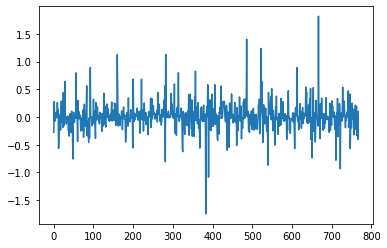

In [19]:
import matplotlib.pyplot as plt
plt.plot(attr[0,16])


The norm of attributions for each input token looks vaguely sensible. Need to check if this matches other attribution methods - 
e.g. using Ecco and Captum Saliency.

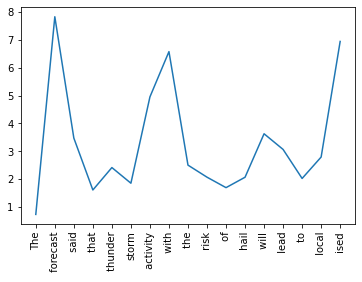

In [57]:
import numpy as np
norms = np.linalg.norm(attr[0], axis=1)
labels = [tokenizer.decode(token) for token in tokens[0]]
#plt.plot(labels, norms)
fig, ax = plt.subplots()
ax.plot(norms)
ax.set_xticks(np.arange(attr.shape[1]))

ax.set_xticklabels(labels,rotation='vertical')
plt.show()


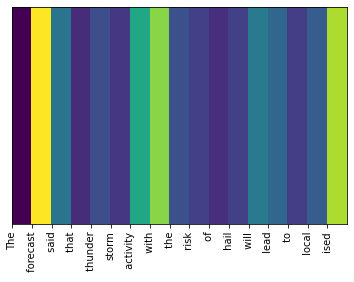

In [49]:
norms = np.linalg.norm(attr[0], axis=1)
#plt.pcolor(norms[np.newaxis,:])
fig, ax = plt.subplots()
ax.pcolor(norms[np.newaxis,:])
ax.set_xticks(np.arange(attr.shape[1]))
ax.set_yticks([])
ax.set_xticklabels(labels,rotation='vertical')
plt.show()

No obvious pattern in showing full attribution vectors for all input embedding vectors. 

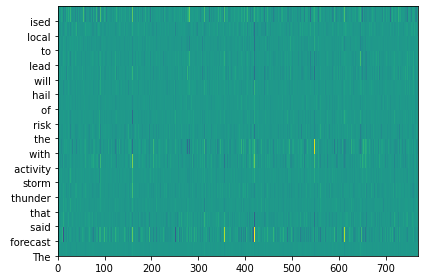

In [32]:
norms = map(norm,attr[0])
fig, ax = plt.subplots()
ax.pcolor(attr[0])
#ax.imshow(norms[np.newaxis,:])
ax.set_yticks(np.arange(attr.shape[1]))
ax.set_yticklabels(labels)
fig.tight_layout()
plt.show()

Next step is to attribute from output logits to hidden layers and history.

The idea would be to generate a [Graph_(discrete_mathematics)](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) based on whether attribution is from earlier positions or lower layers